# Importing libraries and setting up functions

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sqlite3

%matplotlib inline

In [2]:
# takes a SQL query as an argument and returns a pandas dataframe of that query
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

# takes a SQL command as an argument and executes it using the sqlite module
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

# calls the run_query() function to return a list of all tables and views in the database
def show_tables():
    return run_query("SELECT name, type FROM sqlite_master WHERE type IN ('table','view');")

print(show_tables())

              name   type
0            album  table
1           artist  table
2         customer  table
3         employee  table
4            genre  table
5          invoice  table
6     invoice_line  table
7       media_type  table
8         playlist  table
9   playlist_track  table
10           track  table


# Selecting Albums to purchase
<ol>
<li>Write a query that returns each genre, with the number of tracks sold in the USA:
<ul><li>in absolute numbers
<li>in percentages.</ul>
<li>Create a plot to show this data.
<li>Write a paragraph that interprets the data and makes a recommendation for the three artists whose albums we should purchase for the store, based on sales of tracks from their genres.
</ol>

In [3]:
# Setting up the desired query

albums_purchased_query = """
WITH usa_tracks_purchased as (
        select il.* from invoice_line il
        INNER JOIN invoice i on i.invoice_id = il.invoice_id
        INNER JOIN customer c on i.customer_id = c.customer_id
        WHERE c.country = "USA"
        )

SELECT g.name genre,
       count(utp.invoice_line_id) as number_sold,
       cast(count(utp.invoice_line_id) as float) / (
           select count(*) from usa_tracks_purchased
       ) as percent_sold
       from usa_tracks_purchased utp 
       INNER JOIN track t on t.track_id = utp.track_id
       INNER JOIN genre g on g.genre_id = t.genre_id
       GROUP BY 1
       ORDER BY 2 DESC;
        """

# Executing the query to data frame
usa_tracks_purchased = run_query(albums_purchased_query)
print(usa_tracks_purchased)

                 genre  number_sold  percent_sold
0                 Rock          561      0.533777
1   Alternative & Punk          130      0.123692
2                Metal          124      0.117983
3             R&B/Soul           53      0.050428
4                Blues           36      0.034253
5          Alternative           35      0.033302
6                Latin           22      0.020932
7                  Pop           22      0.020932
8          Hip Hop/Rap           20      0.019029
9                 Jazz           14      0.013321
10      Easy Listening           13      0.012369
11              Reggae            6      0.005709
12   Electronica/Dance            5      0.004757
13           Classical            4      0.003806
14         Heavy Metal            3      0.002854
15          Soundtrack            2      0.001903
16            TV Shows            1      0.000951


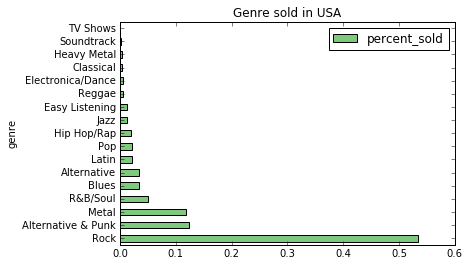

In [4]:
# Creating plot to show the dataset
usa_tracks_purchased.plot(
    kind="barh",
    x="genre",
    y="percent_sold",
    use_index=True,
    title="Genre sold in USA",
    colormap=plt.cm.Accent
)

From the plot, it can be seen that tracks that are of Rock genre are sold out the most and TV show tracks are not much of a sale. Rock tracks make up more than 50 % of the sales. The tracks recommended for the three authors are - 

1. Meteor and the Girls
2. Red Tone
3. Slim Jim Bites 

This makes up about 17% of the total sales

# Analyzing Employee sales performance

1. Write a query that finds the total dollar amount of sales assigned to each sales support agent within the company. Add any extra attributes for that employee that you find are relevant to the analysis.
2. Create a plot of the results of your query.
3. Write a short statement describing your results, and providing a possible interpretation.

In [5]:
# Setting up the desired queries

employee_sales_performance_query = """ SELECT 
                                            e.first_name || ' ' || e.last_name as employee_name,
                                            e.hire_date hire_date, 
                                            SUM(i.total) total_sales_amt from employee e inner join customer c
                                            on e.employee_id = c.support_rep_id inner join invoice i
                                            on i.customer_id = c.customer_id
                                            group by 1
                                    """

# Running the results
employee_sales = run_query(employee_sales_performance_query)
print(employee_sales)

   employee_name            hire_date  total_sales_amt
0   Jane Peacock  2017-04-01 00:00:00          1731.51
1  Margaret Park  2017-05-03 00:00:00          1584.00
2  Steve Johnson  2017-10-17 00:00:00          1393.92


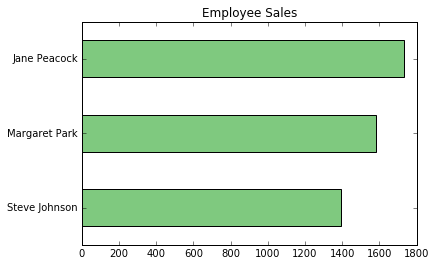

In [6]:
# Plotting the data frame
employee_sales.set_index("employee_name", drop=True, inplace=True)
employee_sales.sort_values("total_sales_amt", inplace=True)

employee_sales.plot(
    kind="barh",
    legend=False,
    title='Employee Sales',
    colormap=plt.cm.Accent
)

plt.ylabel("")

Jane Peacock makes the most number of sales in dollars compared to the other 2 employees. This may be due to the fact that the other two employees are hired later than Jane.

# Analyzing Sales by Country

1. Write a query that collates data on purchases from different countries.
<ul>
<li>Where a country has only one customer, collect them into an "Other" group.
<li>The results should be sorted by the total sales from highest to lowest, with the "Other" group at the very bottom.
<li>For each country, include:
<ul>
<li>total number of customers
<li>total value of sales
<li>average value of sales per customer
<li>average order value
</ul>
</ul>

In [7]:
# Building query for analyzing sales by country

analyze_sales_query = """
WITH country_other as (
        SELECT 
            CASE 
                WHEN (
                    SELECT count(*) 
                    FROM customer where country = c.country
                ) = 1
                THEN "Other"
                ELSE c.country
            END country, c.customer_id,
            il.* FROM invoice_line il
            INNER JOIN invoice i ON i.invoice_id = il.invoice_id
            INNER JOIN customer c ON c.customer_id = i.customer_id 
        )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
"""

sales_analysis = run_query(analyze_sales_query)
print(sales_analysis)

          country  customers  total_sales  average_order  \
0             USA         13      1040.49       7.942672   
1          Canada          8       535.59       7.047237   
2          Brazil          5       427.68       7.011148   
3          France          5       389.07       7.781400   
4         Germany          4       334.62       8.161463   
5  Czech Republic          2       273.24       9.108000   
6  United Kingdom          3       245.52       8.768571   
7        Portugal          2       185.13       6.383793   
8           India          2       183.15       8.721429   
9           Other         15      1094.94       7.448571   

   customer_lifetime_value  
0                80.037692  
1                66.948750  
2                85.536000  
3                77.814000  
4                83.655000  
5               136.620000  
6                81.840000  
7                92.565000  
8                91.575000  
9                72.996000  


# Visualizing Sales by Country

<ol>
<li>For each dimension, create a visualization which demonstrates the data we collated in the previous step.
<ul><li>You should decide whether the "Other" group is relevant to your analysis and make decisions on where to include it (if anywhere) in your visualizations.</ul>
<li>Write a few sentences interpreting your data and visualizations, and make one or more recommendations to the marketing team on which countries have potential for growth.</ol>

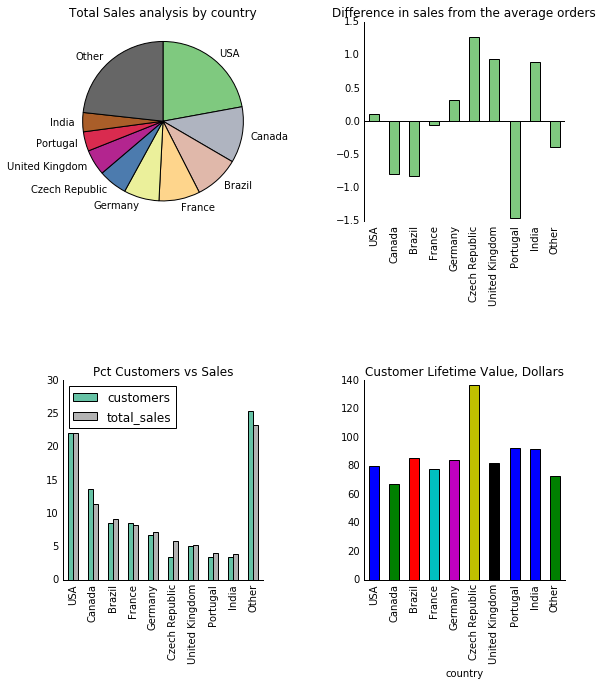

In [8]:
sales_analysis.set_index("country", drop=True, inplace=True)

# Setting up axes for 4 figures
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.8, wspace=.5)

# Top Left Pie Chart
sales_analysis["total_sales"].plot(
    kind="pie",
    y="",
    x="",
    ax=ax1,
    title="Total Sales analysis by country",
    colormap=plt.cm.Accent,
    counterclock=False,
    startangle=90
)
ax1.set_ylabel('')

# Top Right
avg_sales = sales_analysis["average_order"].copy()
avg_sales = avg_sales - avg_sales.mean()

avg_sales.plot(
    kind="bar",
    title="Difference in sales from the average orders",
    ax=ax2,
    colormap=plt.cm.Accent
)

ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.axhline(0, color='k')
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["bottom"].set_visible(False)

ax2.set_xlabel("")

# Bottom Left
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = sales_analysis[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] = (custs_vs_dollars[c] / custs_vs_dollars[c].sum()) * 100

custs_vs_dollars.plot(
    kind="bar",
    ax=ax3,
    colormap=plt.cm.Set2,
    title="Pct Customers vs Sales"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)

# Bottom Right
sales_analysis["customer_lifetime_value"].plot(
    kind="bar",
    ax=ax4,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

Based on the graphs that are visualised, it is noted that Czech Republic has more number of average orders and customer lifetime and the total sales. This shows that, even in the long run, they are more customer centric when compared to other countries.


# Albums VS Individual Tracks

<ol>
<li>Write a query that categorizes each invoice as either an album purchase or not, and calculates the following summary statistics:
<ul>
<li>Number of invoices
<li>Percentage of invoices
</ul>
<li>Write one to two sentences explaining your findings, and making a prospective recommendation on whether the Chinook store should continue to buy full albums from record companies
</ol>

In [9]:
# Setting up queries
albums_vs_tracks = """
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MAX(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
"""

run_query(albums_vs_tracks)


,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


Album purchases account for 18.6% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.